In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import os
import pickle5 as pickle

sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500",
          "#be97c6", "#6e4176"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

# import joypy
import pandas as pd

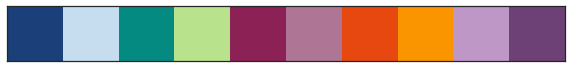

In [72]:
sns.palplot(palette)

In [33]:
mt_preds = torch.load("finance_mt_preds_3.pt")

In [34]:
mt_x_list = mt_preds["x_paths"]

train_splits = list(range(252, 1259, int(252/2)))
eval_splits = list(range(252+int(252/2), 1259, int(252/2))) + [1259]
print(len(train_splits), len(eval_splits))

8 8


In [35]:
train_splits.insert(0,0)

In [36]:
ind_preds = torch.load("finance_ind_preds.pt", map_location="cpu")
ind_x_list = ind_preds["x_paths"]

In [37]:
times = np.arange(0, int(252/2), 20)
times[-1] -= 2

In [38]:
len(times)

7

In [39]:
full_data = ind_preds["y"]

In [40]:
len(eval_splits)

8

In [41]:

mt_quantiles_list = []
ind_quantiles_list = []
for i in range(len(eval_splits)):
    
    torch.cuda.empty_cache()
    
    train_start = train_splits[i]
    train_end = train_splits[i+1]
    test_end = eval_splits[i]
    test_y = full_data[:, train_end:test_end]
    test_y = test_y[:, times].unsqueeze(-2).cpu()
    
    ind_quantiles_list.append((ind_x_list[i][..., times] > test_y).sum(1))
    mt_quantiles_list.append((mt_x_list[i][..., times] > test_y).sum(1))

In [42]:
ind_quantiles = torch.stack(ind_quantiles_list) / 100
mt_quantiles = torch.stack(mt_quantiles_list) / 100

ind_quantiles = ind_quantiles.reshape(-1, 7)
mt_quantiles = mt_quantiles.reshape(-1, 7)

<AxesSubplot:ylabel='Density'>

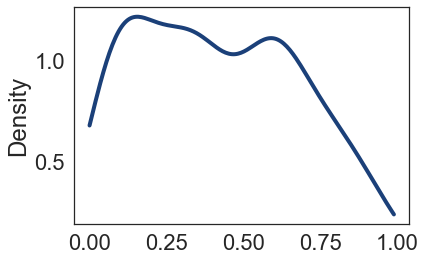

In [43]:
sns.kdeplot(ind_quantiles[..., 1], cut=0)

In [44]:
import pandas as pd

In [45]:
ind_df = pd.DataFrame(
    {"quantiles": ind_quantiles.reshape(-1).numpy(), 
     "date": np.repeat([np.array(times)+1],30*8)}
)

In [46]:
ind_df["date"] = ind_df["date"] #/ (1259/5) #+ 0.7

In [47]:
df = pd.DataFrame(
    {"quantiles": mt_quantiles.reshape(-1).numpy(), 
     "date": np.repeat([np.array(times)+1],30*8)}
)
df["date"] = df["date"] #/ (1259/5)

In [48]:
df["date"]

0         1
1         1
2         1
3         1
4         1
       ... 
1675    119
1676    119
1677    119
1678    119
1679    119
Name: date, Length: 1680, dtype: int64

In [49]:
ind_df["model"] = "Independent"
df["model"] = "Multitask"
full_df = pd.concat((ind_df, df))

Text(0, 0.5, 'Quantile of True Value')

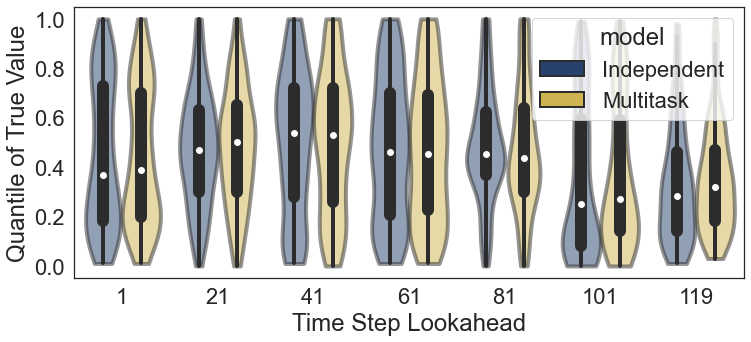

In [50]:
fig, ax = plt.subplots(figsize=(12,5))
violins = sns.violinplot(x='date', y='quantiles', data=full_df, hue="model", cut=0, ax=ax,
                        palette=[palette[0], palette[-2]])
for violin in violins.collections[::2]:
    violin.set_alpha(0.5)
    # violin.set_edgecolor(palette[-2])
    
plt.xlabel("Time Step Lookahead")
plt.ylabel("Quantile of True Value")
# violins = sns.violinplot(x='date', y='quantiles', data=df, color=palette[0], cut=0,ax=ax)
# for violin in violins.collections[::2]:
#     violin.set_alpha(0.5)
#     violin.set_edgecolor(palette[1])

In [51]:
def is_covered(vec, test_pt, sd_scale=1.96):
    vec_mean = vec.mean(1)
    vec_std = vec.std(1)
    return ((vec_mean - sd_scale * vec_std) <= test_pt) * ((vec_mean + sd_scale * vec_std) >= test_pt)

In [52]:
%pdb

Automatic pdb calling has been turned OFF


In [53]:

mt_sd_list = []
ind_sd_list = []
for i in range(len(eval_splits)):
    
    torch.cuda.empty_cache()
    
    train_start = train_splits[i]
    train_end = train_splits[i+1]
    test_end = eval_splits[i]
    test_y = full_data[:, train_end:test_end]
    test_y = test_y[:, times]#.unsqueeze(-2).cpu()
    
    mt_sd_list.append(is_covered(mt_x_list[i][..., times], test_y))
    ind_sd_list.append(is_covered(ind_x_list[i][..., times], test_y))

In [54]:
mt_sds = torch.stack(mt_sd_list)
ind_sds = torch.stack(ind_sd_list)

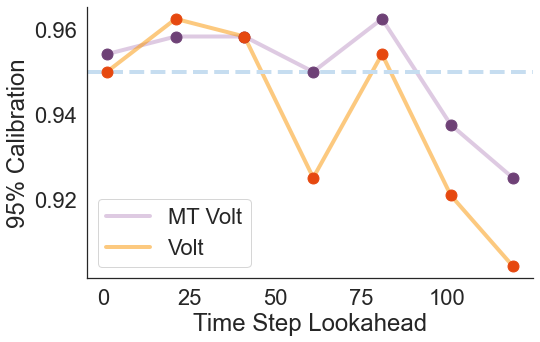

In [76]:
plt.figure(figsize=(8, 5))
plt.plot(times+1, mt_sds.float().mean((0,1)), color = palette[-2], label="MT Volt", alpha = 0.5)
plt.plot(times+1, ind_sds.float().mean((0,1)), color = palette[7], label="Volt", alpha = 0.5)
plt.scatter(times+1, mt_sds.float().mean((0,1)), color = palette[-1], s=120, zorder=4)
plt.scatter(times+1, ind_sds.float().mean((0,1)), color = palette[6], s=120, zorder=4)
plt.xlabel("Time Step Lookahead")
plt.ylabel("95% Calibration")
plt.legend()
plt.axhline(0.95, color = palette[1], linestyle="--")
sns.despine()
plt.savefig("mt_calibration.pdf", bbox_inches = "tight")

In [134]:
mt_sd_list = []
ind_sd_list = []
for i in range(len(eval_splits)):
    
    torch.cuda.empty_cache()
    
    train_start = train_splits[i]
    train_end = train_splits[i+1]
    test_end = eval_splits[i]
    test_y = full_data[:, train_end:test_end]
    test_y = test_y[:, times]#.unsqueeze(-2).cpu()
    
    mt_sd_list.append(is_covered(mt_x_list[i][..., times], test_y, 1.15))
    ind_sd_list.append(is_covered(ind_x_list[i][..., times], test_y, 1.15))

In [135]:
mt_sds = torch.stack(mt_sd_list)
ind_sds = torch.stack(ind_sd_list)

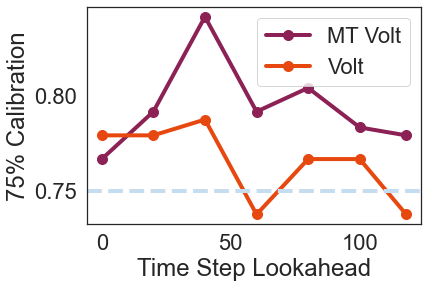

In [136]:
plt.plot(times, mt_sds.float().mean((0,1)), color = palette[4], marker = ".", markersize=20, label="MT Volt")
plt.plot(times, ind_sds.float().mean((0,1)), color = palette[-2], marker = ".", markersize=20, label="Volt")
plt.xlabel("Time Step Lookahead")
plt.ylabel("75% Calibration")
plt.legend()
plt.axhline(0.75, color = palette[1], linestyle="--")